# VirtualiZarr Useful Recipes with NASA Earthdata

#### *Author: Dean Henze, PO.DAAC*

*Reference herein to any specific commercial product, process, or service by trade name, trademark, manufacturer, or otherwise, does not constitute or imply its endorsement by the United States Government or the Jet Propulsion Laboratory, California Institute of Technology.*

## Summary

This notebook goes through several functionalities of the VirtualiZarr package to create virtual reference files, specifically using it with NASA Earthdata and utilizing the `earthaccess` package. It is meant to be a quick-start reference that introduces some key capabilities / characteristics of the package once a user has a high-level understanding of virtual data sets and the cloud-computing challenges they address (see references in the *Prerequisite knowledge* section below). In short, VirtualiZarr is a Python package to create "reference files", which can be thought of as road maps for the computer to efficiently navigate through large arrays in a single data file, or across many files. Once a reference file for a data set is created, utilizing it to open the data can speed up several processes including lazy loading, accessing subsets, and in some cases performing computations. Importantly, one can create a combined reference for all the files in a dataset and use it to lazy load / access the entire record at once.

The functionalities of VirtualiZarr (with earthaccess) covered in this notebook are:

1. **Getting Data File endpoints in Earthdata Cloud** which are needed for virtualizarr to create reference files.
2. **Generating reference files for 1 day, 1 year, and the entire record of a ~750 GB data set**. The data set used is the Level 4 global gridded 6-hourly wind product from the Cross-Calibrated Multi-Platform project (https://doi.org/10.5067/CCMP-6HW10M-L4V31), available on PO.DAAC. This section also covers speeding up the reference creation using parallel computing. Reference files are saved in both JSON and PARQUET formats. The latter is an important format as it reduces the reference file size by ~30x in our tests. *Saving in ice chunk formats will be tested / covered in the coming months.*
3. **Combining reference files (in progress)**. The ability to combine reference files together is valuable, for example to upate reference files for forward-streaming datasets when new data are available, without re-creating the entire record from scratch. However, with the current workflows and version of VirtualiZarr, this is not possible due to our use of a specific kwarg when creating the reference files. The workflow is still included here (with errors) because it is anticipated that this will be fixed in upcoming versions. Alternately, the use of ice chunk will also likely solve this issue (ice chunk functionality to be tested soon). 

## Requirements, prerequisite knowledge, learning outcomes

#### Requirements to run this notebook

* Earthdata login account: An Earthdata Login account is required to access data from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account.

* Compute environment: This notebook is meant to be run in the cloud (AWS instance running in us-west-2). We used an `m6i.4xlarge` EC2 instance (16 CPU's, 64 GiB memory) for the parallel computing sections. At minimum we recommend a VM with 10 CPU's to make the parallel computations in Section 2.2.1 faster.

* Optional Coiled account: To run the section on distributed clusters, Create a coiled account (free to sign up), and connect it to an AWS account. For more information on Coiled, setting up an account, and connecting it to an AWS account, see their website [https://www.coiled.io](https://www.coiled.io). 

#### Prerequisite knowledge

* This notebook covers virtualizarr functionality but does not present the high-level ideas behind it. For an understanding of reference files and how they are meant to enhance in-cloud access to file formats that are not cloud optimized (such netCDF, HDF), please see e.g. this [kerchunk page](https://fsspec.github.io/kerchunk/), or [this page on virtualizarr](https://virtualizarr.readthedocs.io/en/latest/).

* Familiarity with the `earthaccess` and `Xarray` packages. Familiarity with directly accessing NASA Earthdata in the cloud. 

* The Cookbook notebook on [Dask basics](https://podaac.github.io/tutorials/notebooks/Advanced_cloud/basic_dask.html) is handy for those new to parallel computating.

#### Learning Outcomes

This notebook serves both as a pedagogical resource for learning several key workflows as well as a quick reference guide. Readers will gain the understanding to combine the virtualizarr and earthaccess packages to create virtual dataset reference files for NASA Earthdata.

## Import Packages
#### ***Note Zarr Version***
***Zarr version 2 is needed for the current implementation of this notebook, due to (as of February 2025) Zarr version 3 not accepting `FSMap` objects.***

We ran this notebook in a Python 3.12 environment. The minimal working environment we used to run this notebook was:
```
zarr==2.18.4
fastparquet==2024.5.0
xarray==2025.1.2
earthaccess==0.11.0
fsspec==2024.10.0
dask==2024.5.2 ("dask[complete]"==2024.5.2 if using pip)
h5netcdf==1.3.0
matplotlib==3.9.2
jupyterlab
jupyter-server-proxy
virtualizarr==1.3.0
kerchunk==0.2.7
```
And optionally:
```
coiled==1.58.0
```

In [1]:
pip install earthaccess>=0.11.0 zarr>=2.18.4 fastparquet>=2024.5.0 xarray>=2024.1.0  fsspec>=2024.10.0 "dask[complete]">=2024.5.2 h5netcdf>=1.3.0 ujson>=5.10.0 matplotlib>=3.9.2  kerchunk==0.2.7 virtualizarr>=1.3.0 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.37.38 requires botocore<1.38.0,>=1.37.38, but you have botocore 1.37.3 which is incompatible.
s3transfer 0.11.5 requires botocore<2.0a.0,>=1.37.4, but you have botocore 1.37.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install cftime

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip list 

Package                       Version
----------------------------- -----------
aiobotocore                   2.16.0
aiohappyeyeballs              2.4.4
aiohttp                       3.11.11
aioitertools                  0.12.0
aiosignal                     1.3.2
ansiwrap                      0.8.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
asciitree                     0.3.3
asttokens                     2.0.8
async-timeout                 5.0.1
attrs                         22.1.0
awscli                        1.25.53
azure-common                  1.1.28
azure-storage-blob            1.4.0
azure-storage-common          1.4.2
backcall                      0.2.0
backoff                       2.1.2
backports.functools-lru-cache 1.6.4
beautifulsoup4                4.11.1
bleach                        5.0.1
bokeh                         3.7.0
boto3                         1.24.53
botocore                      1.35.81
bounded-pool-executor         0.0.3
cache

In [1]:
# Built-in packages
import os
import sys

# Filesystem management 
import fsspec
import earthaccess

# Data handling
import xarray as xr
from virtualizarr import open_virtual_dataset

# Parallel computing 
import multiprocessing
from dask import delayed
import dask.array as da
from dask.distributed import Client

# parquet zip file
import shutil

# Other
import matplotlib.pyplot as plt
import numpy as np


/home/jovyan/.local/envs/isce/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Other Setup

In [4]:
xr.set_options( # display options for xarray objects
    display_expand_attrs=False,
    display_expand_coords=True,
    display_expand_data=True,
)

## 1. Get Data File S3 endpoints in Earthdata Cloud 
The first step is to find the S3 endpoints to the files. Handling access credentials to Earthdata and then finding the endpoints can be done a number of ways (e.g. using the `requests`, `s3fs` packages) but we use the `earthaccess` package for its ease of use. We get the endpoints for all files in the CCMP record.

In [5]:
# Get Earthdata creds
earthaccess.login()

In [6]:
# Get AWS creds. Note that if you spend more than 1 hour in the notebook, you may have to re-run this line!!!
fs = earthaccess.get_s3_filesystem(daac="PODAAC")

## 2. Open reference files from S3 bucket

The reference can be saved to file and used to open the corresponding CCMP data file with Xarray:

In [7]:
# Open data using the reference file, using a small wrapper function around xarray's open_dataset. 
# This will shorten code blocks in other sections. 
def opends_withref(ref, fs_data):
    """
    "ref" is a reference file or object. "fs_data" is a filesystem with credentials to
    access the actual data files. 
    """
    storage_opts = {"fo": ref, "remote_protocol": "s3", "remote_options": fs_data.storage_options}
    fs_ref = fsspec.filesystem('reference', **storage_opts)
    m = fs_ref.get_mapper('')
    data = xr.open_dataset(
        m, engine="zarr", chunks={},
        backend_kwargs={"consolidated": False}
    )
    return data

In [15]:
%%time

# Open the OSTIA Reprocessed SST reference file (OSTIA-UKMO-L4-GLOB-REP-v2.0)
sst_ds = opends_withref('https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-docs/ghrsst/open/docs/OSTIA-UKMO-L4-GLOB-REP-v2.0_combined-ref.json', fs)
print(sst_ds)
sst_ds

<xarray.Dataset> Size: 11TB
Dimensions:           (time: 15340, lat: 3600, lon: 7200)
Coordinates:
  * lat               (lat) float32 14kB -89.97 -89.93 -89.88 ... 89.93 89.97
  * lon               (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time              (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 202...
Data variables:
    analysed_sst      (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    mask              (time, lat, lon) float32 2TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
Attributes: (39)
CPU times: user 21.5 ms, sys: 0 ns, total: 21.5 ms
Wall time: 20.1 ms


<xarray.Dataset> Size: 11TB
Dimensions:           (time: 15340, lat: 3600, lon: 7200)
Coordinates:
  * lat               (lat) float32 14kB -89.97 -89.93 -89.88 ... 89.93 89.97
  * lon               (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time              (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 202...
Data variables:
    analysed_sst      (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    mask              (time, lat, lon) float32 2TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
Attributes: (39)

In [9]:
%%time

# Open the OSCAR  Currents reference file (OSCAR_L4_OC_FINAL_V2.0)
curr_ds = opends_withref('https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-docs/oscar/open/L4/oscar_v2.0/docs/OSCAR_L4_OC_FINAL_V2.0_combined-ref.json', fs)

# set the 'time' to an understandable ISO format
datetimeindex = curr_ds.indexes['time'].to_datetimeindex()
curr_ds['time'] = datetimeindex

print(curr_ds)
curr_ds

<xarray.Dataset> Size: 358GB
Dimensions:  (latitude: 719, longitude: 1440, time: 10808)
Coordinates:
    lat      (latitude) float64 6kB dask.array<chunksize=(719,), meta=np.ndarray>
    lon      (longitude) float64 12kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * time     (time) datetime64[ns] 86kB 1993-01-01 1993-01-02 ... 2022-08-04
Dimensions without coordinates: latitude, longitude
Data variables:
    u        (time, longitude, latitude) float64 90GB dask.array<chunksize=(1, 720, 360), meta=np.ndarray>
    ug       (time, longitude, latitude) float64 90GB dask.array<chunksize=(1, 720, 360), meta=np.ndarray>
    v        (time, longitude, latitude) float64 90GB dask.array<chunksize=(1, 720, 360), meta=np.ndarray>
    vg       (time, longitude, latitude) float64 90GB dask.array<chunksize=(1, 720, 360), meta=np.ndarray>
Attributes: (36)
CPU times: user 547 ms, sys: 40.6 ms, total: 588 ms
Wall time: 1.73 s


<timed exec>:5: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
<timed exec>:5: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


<xarray.Dataset> Size: 358GB
Dimensions:  (latitude: 719, longitude: 1440, time: 10808)
Coordinates:
    lat      (latitude) float64 6kB dask.array<chunksize=(719,), meta=np.ndarray>
    lon      (longitude) float64 12kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * time     (time) datetime64[ns] 86kB 1993-01-01 1993-01-02 ... 2022-08-04
Dimensions without coordinates: latitude, longitude
Data variables:
    u        (time, longitude, latitude) float64 90GB dask.array<chunksize=(1, 720, 360), meta=np.ndarray>
    ug       (time, longitude, latitude) float64 90GB dask.array<chunksize=(1, 720, 360), meta=np.ndarray>
    v        (time, longitude, latitude) float64 90GB dask.array<chunksize=(1, 720, 360), meta=np.ndarray>
    vg       (time, longitude, latitude) float64 90GB dask.array<chunksize=(1, 720, 360), meta=np.ndarray>
Attributes: (36)

In [10]:
%%time

# Open the CCMP Winds reference file (CCMP_WINDS_10M6HR_L4_V3.1)
wind_ds = opends_withref('https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-docs/ccmp/open/L4_V3.1/docs/CCMP_WINDS_10M6HR_L4_V3.1_combined-ref.json', fs)

print(wind_ds)
wind_ds


<xarray.Dataset> Size: 775GB
Dimensions:    (latitude: 720, longitude: 1440, time: 46696)
Coordinates:
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * time       (time) datetime64[ns] 374kB 1993-01-02 ... 2024-12-31T18:00:00
Data variables:
    nobs       (time, latitude, longitude) float32 194GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    uwnd       (time, latitude, longitude) float32 194GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vwnd       (time, latitude, longitude) float32 194GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ws         (time, latitude, longitude) float32 194GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (44)
CPU times: user 557 ms, sys: 90.1 ms, total: 647 ms
Wall time: 1.82 s


<xarray.Dataset> Size: 775GB
Dimensions:    (latitude: 720, longitude: 1440, time: 46696)
Coordinates:
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * time       (time) datetime64[ns] 374kB 1993-01-02 ... 2024-12-31T18:00:00
Data variables:
    nobs       (time, latitude, longitude) float32 194GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    uwnd       (time, latitude, longitude) float32 194GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vwnd       (time, latitude, longitude) float32 194GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ws         (time, latitude, longitude) float32 194GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (44)

sst values  [287.0301204  287.01606848 287.00164356 286.95209465 286.8191139
 286.71456265 286.70846473 286.62751198 286.58503415 286.53776356
 286.4563089  286.40576073 286.3360514  286.29248006 286.26468965
 286.22489956 286.21085265 286.1779954  286.16368756 286.16663223]
wind values  [ 8.252176   7.5386257  7.6651707  7.68106    7.7581882  7.2304873
  7.498919   7.7458334  8.901463   8.895283   9.289004  10.274736
 10.737809  11.39235   11.354185  11.176685  10.480244  10.627729
  9.789292   9.514713 ]
current values  [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
done w data conditioning 1



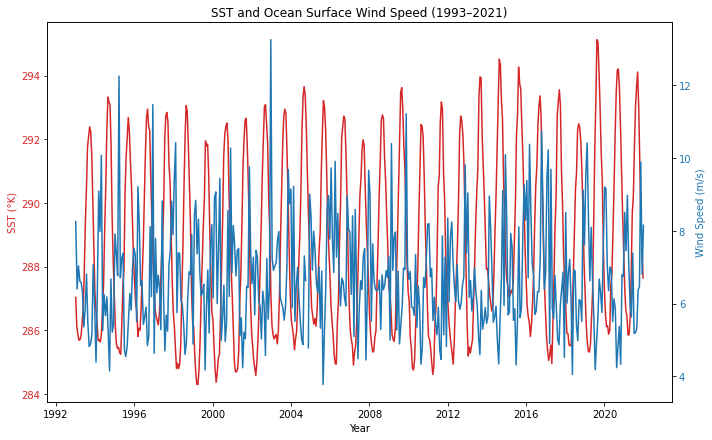

CPU times: user 33.2 s, sys: 1.73 s, total: 34.9 s
Wall time: 56.7 s


In [16]:
%%time
# Try a comparison and plotting exercise

# Define region as a box within -180 to 180 degree longitudes, -90 to 90 latitudes
lon_slice = slice(-150, -125)
lat_slice = slice(33, 45)

# Define the time slice
start_date = '1993-01-01'
end_date = '2021-12-31'

# Subset the datasets
# OSTIA SST
sst = sst_ds['analysed_sst'].sel(lon=lon_slice, lat=lat_slice, time=slice(start_date, end_date))

# CCMP Wind 
lon_slice = slice(210, 245)
u_wind = wind_ds['uwnd'].sel(longitude=lon_slice, latitude=lat_slice, time=slice(start_date, end_date))
v_wind = wind_ds['vwnd'].sel(longitude=lon_slice, latitude=lat_slice, time=slice(start_date, end_date))

# OSCAR Current uses 0-360 deg longitudes
lon_slice = slice(210, 245)
u_curr = curr_ds['u'].sel(longitude=lon_slice, latitude=lat_slice, time=slice(start_date, end_date))
v_curr = curr_ds['v'].sel(longitude=lon_slice, latitude=lat_slice, time=slice(start_date, end_date))

# Compute regional means
sst_mean = sst.mean(dim=["lat", "lon"])

wind_speed = np.sqrt(u_wind**2 + v_wind**2)
wind_speed_mean = wind_speed.mean(dim=["latitude", "longitude"])

current = np.sqrt(u_curr**2 + v_curr**2)
current_mean = current.mean(dim=["latitude", "longitude"])

print("sst values ", sst_mean[0:20].values)
print("wind values ", wind_speed_mean[0:20].values)
print("current values ", current_mean[0:20].values)
print("done w data conditioning 1\n")

# Convert to monthly or annual means 
#sst_resample = sst_mean.resample(time="1YE").mean()
#wind_speed_resample = wind_speed_mean.resample(time="1YE").mean()
#current_resample = current_mean.resample(time="1YE").mean()

#use a dask cluster to parallize

# dump some values
#print("sst values ", sst_resample[0:20].values)
#print("wind values ", wind_speed_resample[0:20].values)
#print("current values ", current_resample[0:20].values)
#print("done w data conditioning 2 (resample)")

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('SST (°K)', color=color)
#ax1.plot(sst_resample['time'], sst_resample, color=color, label='SST')
ax1.plot(sst_mean['time'][::20], sst_mean[::20], color=color, label='SST')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Wind Speed (m/s)', color=color)
#ax2.plot(wind_speed_resample['time'], wind_speed_resample, color=color, label='Current Speed')
ax2.plot(wind_speed_mean['time'][::100], wind_speed_mean[::100], color=color, label='Current Speed')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("SST and Ocean Surface Wind Speed (1993–2021)")
plt.show()

#### For us, lazy loading the entire record took ~3 seconds. Compare that to an attempt at opening these same files with `Xarray` the "traditional" way with a call to `xr.open_mfdataset()`. On a smaller machine, the following line of code will either fail or take a long (possibly very long) amount of time:

In [ ]:
## You can try un-commenting and running this but your notebook will probably stall or crash:
# fobjs = earthaccess.open(granule_info)
# data = xr.open_mfdataset(fobjs[:])